In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import random

np.random.seed(42)

# Step 1: Generate Temporary Loan Table
NUM_CUSTOMERS = 4000
CUSTOMER_IDS = list(range(1, NUM_CUSTOMERS + 1))
LOAN_PURPOSES = ["moving", "debt consolidation", "credit card", "wedding", "home renovation", "others"]

loans = []
for customer_id in CUSTOMER_IDS:
    loan_purpose = np.random.choice(LOAN_PURPOSES, p=[0.1, 0.2, 0.15, 0.1, 0.3, 0.15])
    loan_amount = max(0, int(np.random.normal(50000 if loan_purpose in ["moving", "home renovation"] else 10000, 10000)))
    past_due_days = max(0, int(np.random.normal(30, 10))) if loan_purpose == "debt consolidation" else 0

    loans.append({
        "customer_id": customer_id,
        "loan_amount": loan_amount,
        "loan_purpose": loan_purpose,
        "past_due_days": past_due_days
    })

loans_df = pd.DataFrame(loans)


# Step 2: Generate Temporary Customer Table
customers = []
for customer_id in CUSTOMER_IDS:
    income = max(20000, int(np.random.normal(60000, 20000)))
    balance = max(1000, int(np.random.lognormal(mean=10, sigma=0.5)))
    age = max(18, min(80, int(np.random.normal(40, 12))))
    tenure = random.randint(6, 240)
    dependents = np.random.choice([0, 1, 2, 3], p=[0.5, 0.3, 0.15, 0.05])
    married = np.random.choice([0, 1], p=[0.6, 0.4])

    customers.append({
        "customer_id": customer_id,
        "income": income,
        "balance": balance,
        "age": age,
        "tenure": tenure,
        "dependents": dependents,
        "married": married
    })

customers_df = pd.DataFrame(customers)


# Step 3: Generate Temporary Transactions Table
transactions = []
for customer_id in CUSTOMER_IDS:
    avg_transaction_amount = max(10, np.random.normal(100, 50))
    transaction_frequency = np.random.poisson(5)

    transactions.append({
        "customer_id": customer_id,
        "avg_transaction_amount": avg_transaction_amount,
        "transaction_frequency": transaction_frequency
    })

transactions_df = pd.DataFrame(transactions)


# Step 4: Merge all three tables
combined_df = customers_df.merge(loans_df, on="customer_id").merge(transactions_df, on="customer_id")


# Step 5: Generate Product Ownership based on Conditional Probabilities
product_ownership = pd.DataFrame({"customer_id": CUSTOMER_IDS})

# Calculate DTI Ratio
combined_df['dti_ratio'] = combined_df['loan_amount'] / (combined_df['income'] + 1)


# Investment Product: High income, high balance, low DTI OR high avg transaction
investment_prob = (
    norm.cdf(combined_df['income'], 60000, 20000) * 0.5 +
    (combined_df['balance'] / 100000) * 0.3 +
    (combined_df['tenure'] / 240) * 0.2 +
    (combined_df['avg_transaction_amount'] / 500)
)
product_ownership['has_investment_product'] = np.random.binomial(1, (investment_prob / investment_prob.max()))


# Credit Card: Moderate income, stable balance, or higher transaction frequency
credit_card_prob = (
    norm.cdf(combined_df['income'], 30000, 15000) * 0.7 +
    (combined_df['balance'] / 100000) * 0.2 +
    (combined_df['transaction_frequency'] / 10) * 0.1
)
product_ownership['has_credit_card'] = np.random.binomial(1, (credit_card_prob / credit_card_prob.max()))

# Ensure that if loan_purpose is 'credit card', has_credit_card is forced to 1
product_ownership.loc[combined_df['loan_purpose'] == 'credit card', 'has_credit_card'] = 1


# Home Loan: Loan amount > 0, older age, married, loan purpose
product_ownership['has_home_loan'] = (
    (combined_df['loan_amount'] > 0) &
    (combined_df['age'] > 35) &
    (combined_df['married'] == 1) &
    combined_df['loan_purpose'].isin(["moving", "home renovation"])
).astype(int)

# Force home loan = 1 if loan_purpose is 'moving' or 'home renovation'
product_ownership.loc[combined_df['loan_purpose'].isin(["moving", "home renovation"]), 'has_home_loan'] = 1


# Personal Loan: High DTI, loan amount > 0, loan purpose, or past due loans
product_ownership['has_personal_loan'] = (
    ((combined_df['dti_ratio'] > 0.4) & (combined_df['loan_amount'] > 0)) | 
    (combined_df['past_due_days'] > 0)
).astype(int)

# Force personal loan = 1 if loan_purpose is 'debt consolidation', 'credit card', or 'wedding'
product_ownership.loc[combined_df['loan_purpose'].isin(["debt consolidation", "credit card", "wedding"]), 'has_personal_loan'] = 1


# Fixed Deposit: High balance, long tenure, or older age
fixed_deposit_prob = (
    (combined_df['balance'] / 100000) * 0.5 +
    (combined_df['tenure'] / 240) * 0.3 +
    (combined_df['age'] / 80) * 0.2
)
product_ownership['has_fixed_deposit'] = np.random.binomial(1, (fixed_deposit_prob / fixed_deposit_prob.max()))


# Insurance: Age, dependents, or stable income
insurance_prob = (
    (combined_df['age'] / 80) * 0.5 +
    (combined_df['dependents'] / 3) * 0.3 +
    norm.cdf(combined_df['income'], 60000, 20000) * 0.2
)
product_ownership['has_insurance'] = np.random.binomial(1, (insurance_prob / insurance_prob.max()))


# Step 6: Final Merged Data
final_df = product_ownership.merge(combined_df, on="customer_id")

final_df


,customer_id,has_investment_product,has_credit_card,has_home_loan,has_personal_loan,has_fixed_deposit,has_insurance,income,balance,age,tenure,dependents,married,loan_amount,loan_purpose,past_due_days,avg_transaction_amount,transaction_frequency,dti_ratio
0,1,0,1,0,1,0,0,66541,16464,44,82,0,1,0,credit card,0,140.477288,7,0.000000
1,2,0,0,0,1,0,1,33598,19547,55,217,3,1,13189,debt consolidation,45,168.520090,4,0.392541
2,3,0,1,1,1,0,1,58858,39550,20,103,0,1,57674,moving,0,178.359766,4,0.979867
3,4,0,1,0,0,0,0,63332,37420,25,140,0,1,5305,others,0,117.814327,4,0.083764
4,5,0,1,0,1,1,0,39747,8368,33,181,0,1,15425,debt consolidation,24,55.458867,7,0.388070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3996,0,1,1,1,0,1,82273,38431,41,12,0,0,38445,home renovation,0,68.212366,2,0.467280
3996,3997,1,0,1,1,0,1,64614,18245,38,52,2,0,57250,home renovation,0,29.518455,4,0.886017
3997,3998,0,1,1,1,0,1,81252,34933,42,189,1,0,78652,home renovation,0,91.742305,4,0.967989
3998,3999,0,0,0,1,0,1,83810,14835,54,99,2,0,980,wedding,0,56.711612,6,0.011693


C:\Users\sybel\AppData\Local\Temp\ipykernel_22444\4114580249.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ownership_counts.index, y=ownership_counts.values, palette='viridis')


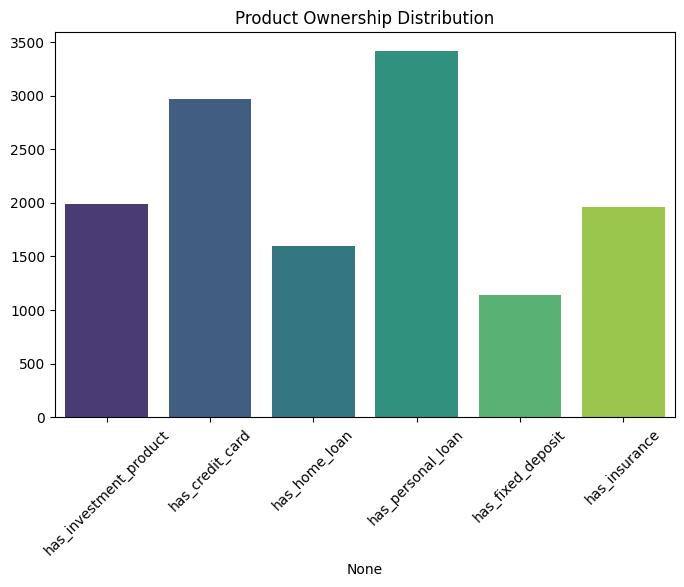

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of customers who own each product
ownership_counts = product_ownership.drop(columns=['customer_id']).sum()

plt.figure(figsize=(8, 5))
sns.barplot(x=ownership_counts.index, y=ownership_counts.values, palette='viridis')
plt.title('Product Ownership Distribution')
plt.xticks(rotation=45)
plt.show()
